In [1]:
import os
import torch
import sys
sys.path.append("../")
import argparse
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import logging 

from model.unet import Unet
class DiceBCELoss(nn.Module):
    def __init__(self, weight=0.5, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = self.weight*BCE + (1-self.weight)*dice_loss
        
        return Dice_BCE
def dice_score(inputs, targets, smooth=1):    
    
    # inputs = F.sigmoid(inputs)  
    #flatten label and prediction tensors
    pred = torch.flatten(inputs)
    true = torch.flatten(targets)
    
    # pred = torch.flatten(inputs)
    # true = torch.flatten(targets)
    
    intersection = (pred * true).sum()
    coeff = (2.*intersection + smooth)/(pred.sum() + true.sum() + smooth)
    return coeff 


/Users/zezzz/anaconda3/envs/gvit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Unet(n_class=1)
path = "/Users/zezzz/work/apt/unet-paip"
model.load_state_dict(torch.load(os.path.join(path, "best_score_model.pth")))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = DiceBCELoss()
# device = torch.device("cuda" if torch.cuda.is_available() else "mps")
# model.to(device)

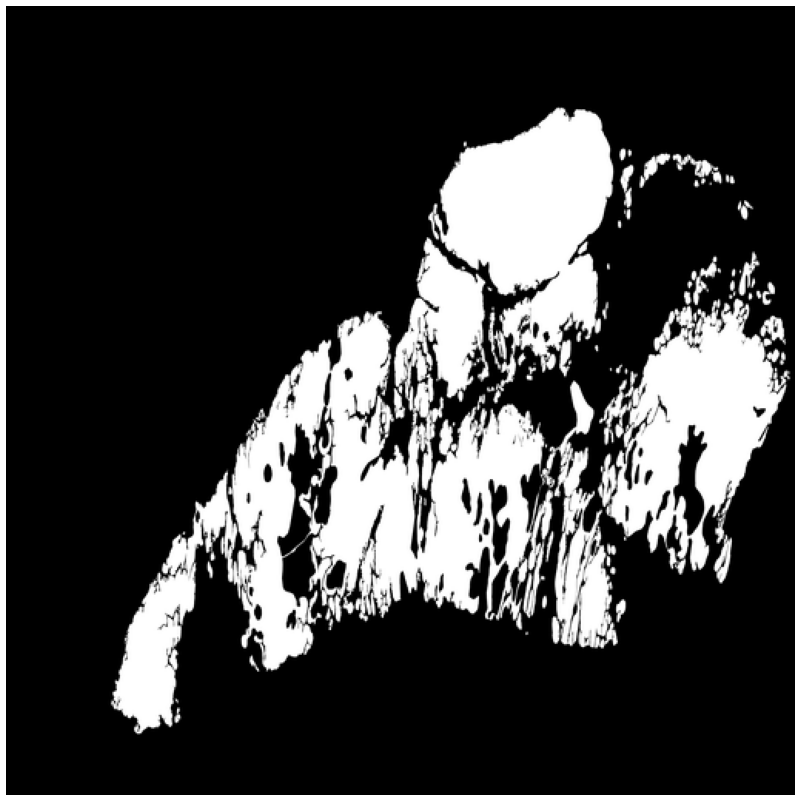

In [3]:
import numpy as np
import cv2 as cv
res = 512
# img = cv.imread(f'/Users/zezzz/Downloads/samples/131900-2019-01-00-03-01/rescaled_image_0_{res}x{res}.png') 
# img = cv.imread(f'/Users/zezzz/Downloads/samples/149600-2019-01-00-03-01/rescaled_image_0_{res}x{res}.png') 
img = cv.imread(f'/Users/zezzz/Downloads/samples/150500-2019-01-00-03-01/rescaled_mask_0_{res}x{res}.png')

fig, ax = plt.subplots(figsize=(16, 16), dpi=64)
plt.imshow(img)
ax.axis("off")
plt.show()
plt.close()

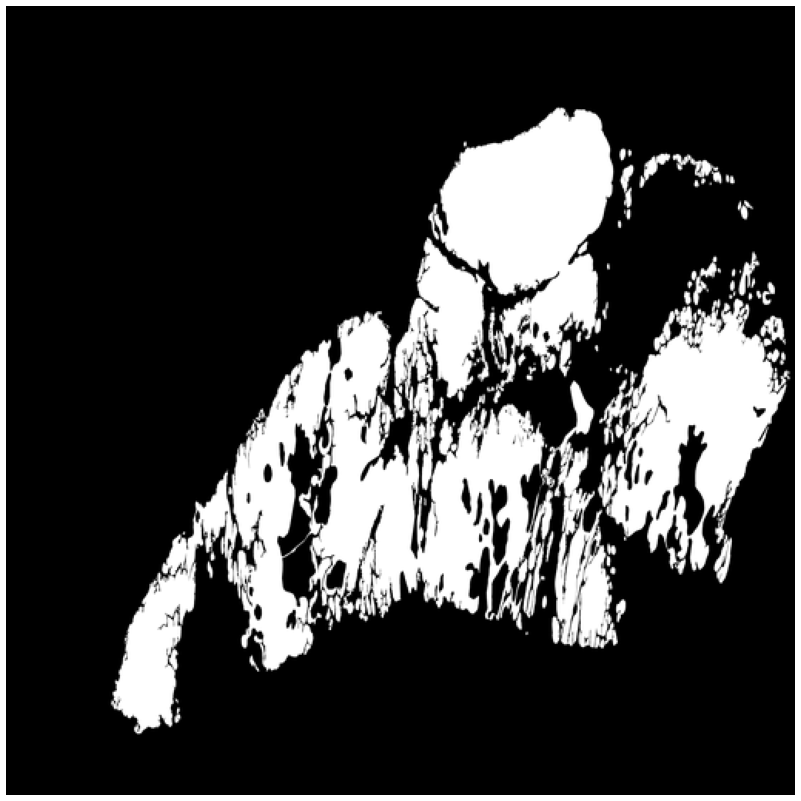

In [4]:
#train step
from PIL import Image, ImageFile
import torchvision.transforms as transforms

# mask_name = f'/Users/zezzz/Downloads/samples/149600-2019-01-00-03-01/rescaled_mask_0_{res}x{res}.png'
# mask_name = f'/Users/zezzz/Downloads/samples/131900-2019-01-00-03-01/rescaled_mask_0_{res}x{res}.png'
mask_name = f'/Users/zezzz/Downloads/samples/150500-2019-01-00-03-01/rescaled_mask_0_{res}x{res}.png'

mask = Image.open(mask_name).convert("L")

fig, ax = plt.subplots(figsize=(16, 16), dpi=64)
plt.imshow(mask)
ax.imshow(mask, cmap = 'gray')
ax.axis("off")
plt.show()
plt.close()

transform = transforms.Compose([
    transforms.ToTensor(),
])
mask = transform(mask)
# mask = mask.to(torch.float32)


In [5]:
mask.shape
mask = mask.view(1,1,res,res)
# print(mask.dtype,output.dtype)


In [6]:
for i in range(20):
    img = torch.Tensor(img)
    print(img.shape)
    img = img.view(-1, 3,res,res)
    print(img.shape)
    output = model(img)
    output = torch.sigmoid(output)
    print(output.shape)

    optimizer.zero_grad()
    loss = criterion(output, mask)
    print(loss)
    score = dice_score(output, mask)
    print(score)
    loss.backward()
    optimizer.step()

torch.Size([512, 512, 3])
torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])
tensor(0.9085, grad_fn=<AddBackward0>)
tensor(0.3222, grad_fn=<DivBackward0>)
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])
tensor(0.6208, grad_fn=<AddBackward0>)
tensor(0.5100, grad_fn=<DivBackward0>)
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])
tensor(0.4802, grad_fn=<AddBackward0>)
tensor(0.5542, grad_fn=<DivBackward0>)
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])
tensor(0.4286, grad_fn=<AddBackward0>)
tensor(0.5663, grad_fn=<DivBackward0>)
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])
tensor(0.3930, grad_fn=<AddBackward0>)
tensor(0.5852, grad_fn=<DivBackward0>)
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 1, 512, 512])
tensor(0.3649, grad_fn=<AddBackward0>)
tensor(0.6078, grad_fn=<DivBackward0>)
torch.Size([1

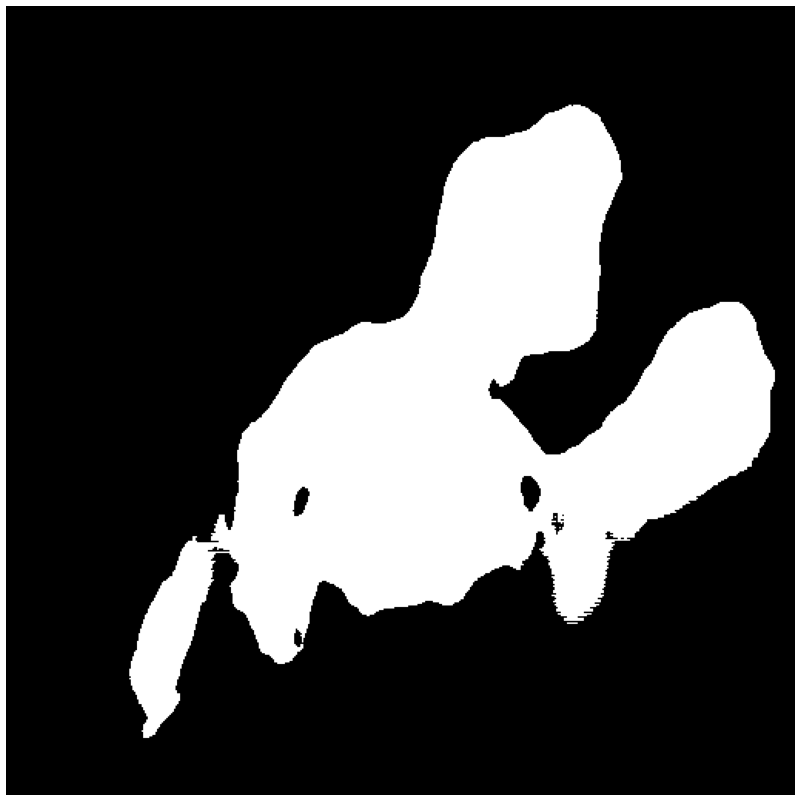

In [7]:
mask_pred = (output[0, 0].cpu() > 0.5).numpy()
fig, ax = plt.subplots(figsize=(16, 16), dpi=64)
plt.imshow(mask_pred)
ax.imshow(mask_pred, cmap = 'gray')
ax.axis("off")
plt.savefig("mask_pred_ap-unetr.png", bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
def dice_score_np(array1, array2):
    # Ensure arrays are binary
    array1 = array1.astype(bool)
    array2 = array2.astype(bool)

    # Calculate intersection and sizes
    intersection = np.logical_and(array1, array2).sum()
    size_sum = array1.sum() + array2.sum()

    # Avoid division by zero
    if size_sum == 0:
        return 1.0  # Both arrays are empty, so they match perfectly

    return 2.0 * intersection / size_sum
print(dice_score(mask[0,0].detach().numpy(),output[0,0].detach().numpy()))

In [ ]:
print(mask.shape)
print(output.shape)